In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib



## Data Preprocessing Function

In [3]:
def preprocess_data(df, target_column='Diagnosis'):
    """
    Preprocess the dataset: handle missing values, encode categorical variables
    """
    X = df.drop(columns=[target_column,'DoctorInCharge'])
    y = df[target_column]

    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    print(f"Categorical columns: {cat_cols}")
    print(f"Numerical columns: {num_cols}")

    label_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

    if y.dtype == 'object':
        target_encoder = LabelEncoder()
        y = target_encoder.fit_transform(y)
        print(f"Target classes: {target_encoder.classes_}")

    return X, y, num_cols, cat_cols, label_encoders



## Random Forest Model Training

In [4]:
def build_and_train_model(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=random_state)),
        ('classifier', RandomForestClassifier(random_state=random_state, n_jobs=-1))
    ])

    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__class_weight': ['balanced']
    }

    print("\nPerforming Grid Search for Random Forest...")
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)

    return best_model, X_train, X_test, y_train, y_test, y_pred, y_pred_proba


## Logistic Regression Model Training

In [5]:
def build_and_train_logistic_regression(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print("\nPerforming Grid Search for Logistic Regression...")
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=random_state)),
        ('classifier', LogisticRegression(random_state=random_state, max_iter=1000))
    ])

    param_grid = {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__class_weight': ['balanced', None]
    }

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)

    return best_model, X_train, X_test, y_train, y_test, y_pred, y_pred_proba



## Model Evaluation Function

In [6]:
def evaluate_model(y_test, y_pred, y_pred_proba, model_name='Model'):
    print("\n" + "=" * 60)
    print(f"{model_name.upper()} EVALUATION")
    print("=" * 60)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'ROC Curve - {model_name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
    else:
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

    print(f"\nROC-AUC Score: {roc_auc:.4f}")
    return roc_auc


## Feature Importance Plot

In [7]:
def plot_feature_importance(model, feature_names, model_name='Random Forest'):
    classifier = model.named_steps['classifier']

    if isinstance(classifier, RandomForestClassifier):
        importances = classifier.feature_importances_
        title = f'Feature Importances - {model_name}'
        xlabel = 'Importance'
    elif isinstance(classifier, LogisticRegression):
        importances = np.abs(classifier.coef_[0])
        title = f'Feature Coefficients - {model_name}'
        xlabel = 'Absolute Coefficient Value'

    indices = np.argsort(importances)[::-1][:20]
    plt.figure(figsize=(9, 6))
    plt.barh(range(20), importances[indices])
    plt.yticks(range(20), [feature_names[i] for i in indices])
    plt.xlabel(xlabel)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()


## Model Comparison

In [8]:
def compare_models(rf_auc, lr_auc):
    print("\n" + "=" * 60)
    print("MODEL COMPARISON SUMMARY")
    print("=" * 60)
    print(f"Random Forest ROC-AUC: {rf_auc:.4f}")
    print(f"Logistic Regression ROC-AUC: {lr_auc:.4f}")

    if rf_auc > lr_auc:
        print(f"Random Forest performs better by {rf_auc - lr_auc:.4f}")
    else:
        print(f"Logistic Regression performs better by {lr_auc - rf_auc:.4f}")


## Run the Full Pipeline

Categorical columns: []
Numerical columns: ['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']
Training set size: 1719
Test set size: 430

Performing Grid Search for Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation score: 0.9420

Performing Grid Search for Logistic Regression...
Fitting 5 

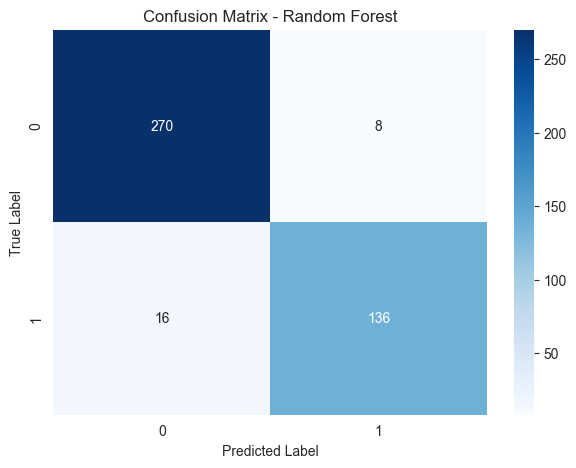

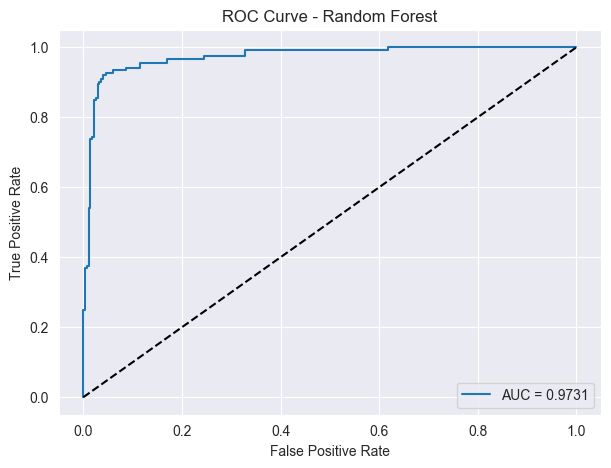


ROC-AUC Score: 0.9731

LOGISTIC REGRESSION EVALUATION

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84       278
           1       0.68      0.84      0.75       152

    accuracy                           0.80       430
   macro avg       0.79      0.81      0.79       430
weighted avg       0.82      0.80      0.81       430



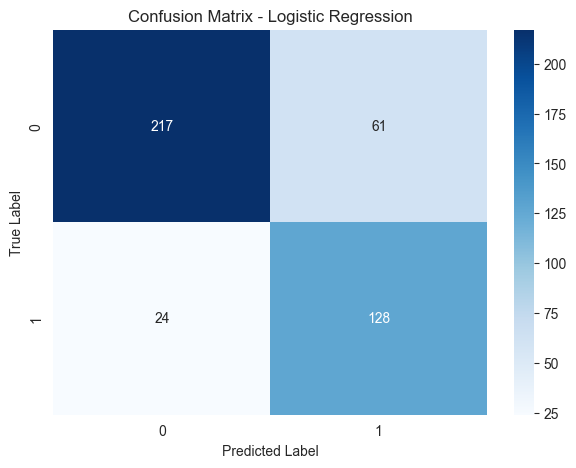

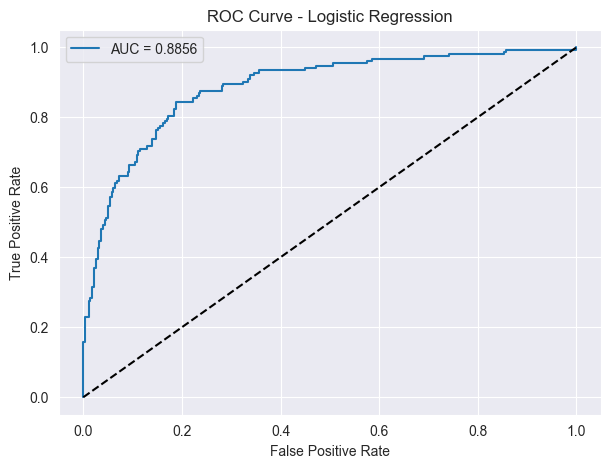


ROC-AUC Score: 0.8856

MODEL COMPARISON SUMMARY
Random Forest ROC-AUC: 0.9731
Logistic Regression ROC-AUC: 0.8856
Random Forest performs better by 0.0875


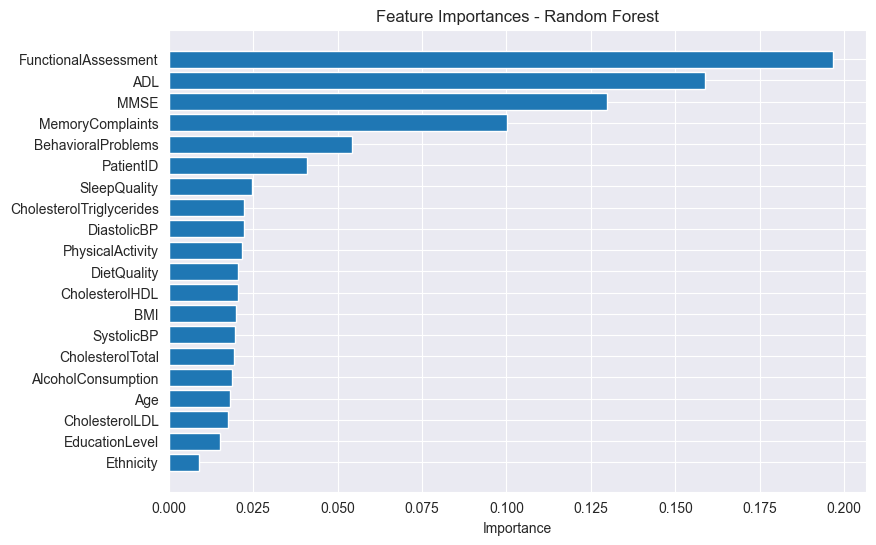

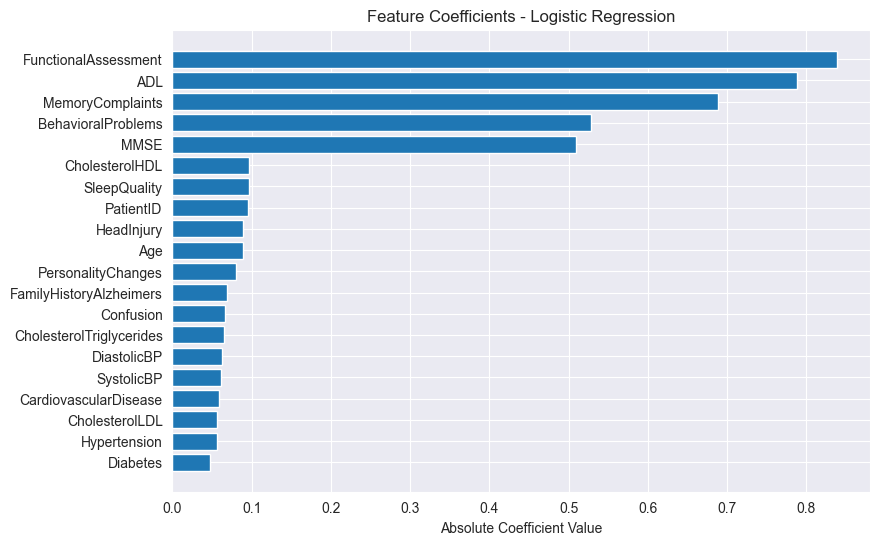


Models saved successfully!


In [9]:
# Load your dataset
df = pd.read_csv('models&data/alzheimers_disease_data.csv')

# Preprocess
X, y, num_cols, cat_cols, label_encoders = preprocess_data(df, target_column='Diagnosis')

# Train models
rf_model, X_train, X_test, y_train, y_test, rf_pred, rf_proba = build_and_train_model(X, y)
lr_model, _, _, _, _, lr_pred, lr_proba = build_and_train_logistic_regression(X, y)

# Evaluate
rf_auc = evaluate_model(y_test, rf_pred, rf_proba, 'Random Forest')
lr_auc = evaluate_model(y_test, lr_pred, lr_proba, 'Logistic Regression')

# Compare
compare_models(rf_auc, lr_auc)

# Plot feature importance
plot_feature_importance(rf_model, X.columns, 'Random Forest')
plot_feature_importance(lr_model, X.columns, 'Logistic Regression')

# Save models
joblib.dump(rf_model, 'models&data/alzheimer_rf_model.pkl')
joblib.dump(lr_model, 'models&data/alzheimer_lr_model.pkl')
print("\nModels saved successfully!")
